In [2]:
import xarray as xr
from pathlib import Path
from typing import Iterable, List
import matplotlib.pyplot as plt
def load_netcdfs(paths: Iterable[Path]) -> List[xr.Dataset]:
    """Loads a list of netCDF files"""
    return [xr.open_dataset(p.as_posix()) for p in paths]

In [4]:
grid_paths = Path('Grids').glob('*.nc')
grids = load_netcdfs(grid_paths)

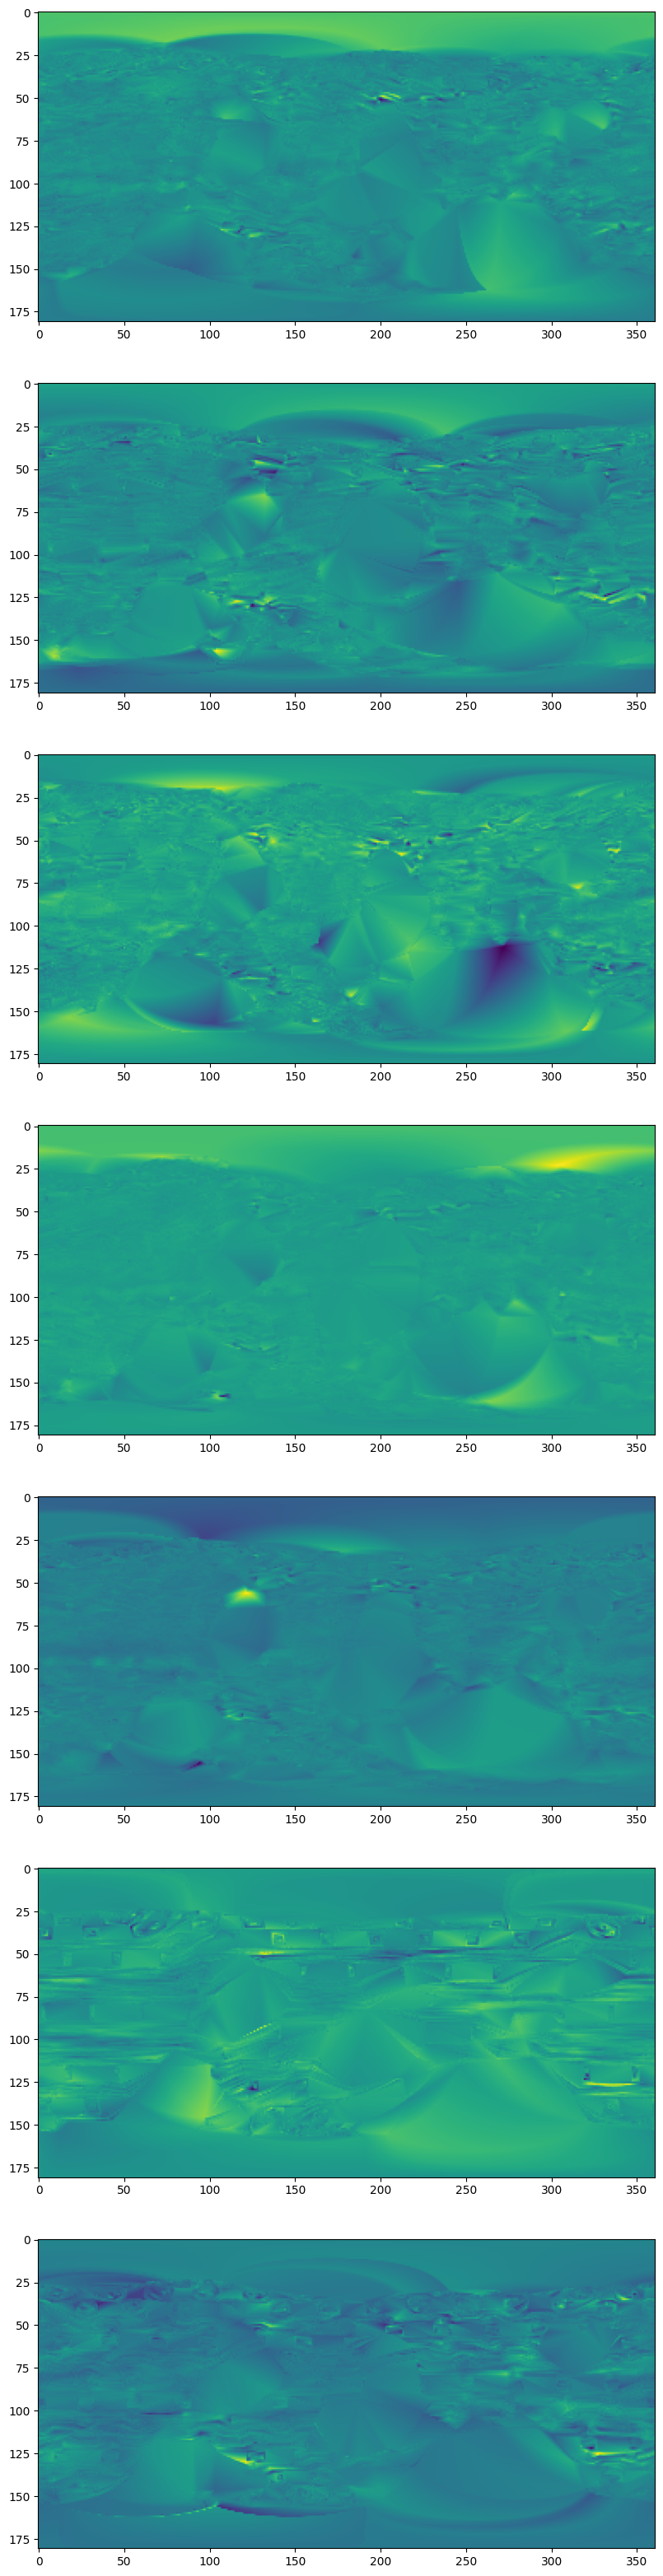

In [7]:
fig, axes = plt.subplots(len(grids), 1, figsize=(12,40))
for grid, ax in zip(grids, axes.flatten()):
    ax.imshow(grid.z.data)
plt.show()